In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/sample_data/train.csv")

In [ ]:
CATEGORY_TO_MAIN = {
    "Financial Fraud": [
        "Cryptocurrency Crime", "Online Financial Fraud", "Online Gambling  Betting"
    ],
    "WomenChildren Related Crime": [
        "Child Pornography CPChild Sexual Abuse Material CSAM", "RapeGang Rape RGRSexually Abusive Content",
        "Sexually Explicit Act", "Sexually Obscene material"
    ],
    "Other Cyber Crimes": [
        "Any Other Cyber Crime", "Cyber Terrorism", "Online Cyber Trafficking",
        "Cyber Attack/ Dependent Crimes", "Hacking  Damage to computercomputer system etc",
        "Ransomware", "Online and Social Media Related Crime"
    ]
}

In [ ]:
# Function to map category to main_category
def get_main_category(category):
    for main_cat, sub_cats in CATEGORY_TO_MAIN.items():
        if category in sub_cats:
            return main_cat
    return "Unknown"

# Apply the function to create the new column
df["main_category"] = df["category"].apply(get_main_category)

# Display the updated DataFrame
print(df)


                                    category  \
0      Online and Social Media Related Crime   
1                     Online Financial Fraud   
2                   Online Gambling  Betting   
3      Online and Social Media Related Crime   
4                     Online Financial Fraud   
...                                      ...   
93681                 Online Financial Fraud   
93682                 Online Financial Fraud   
93683                 Online Financial Fraud   
93684  Online and Social Media Related Crime   
93685                 Online Financial Fraud   

                            sub_category  \
0      Cyber Bullying  Stalking  Sexting   
1                      Fraud CallVishing   
2               Online Gambling  Betting   
3                       Online Job Fraud   
4                      Fraud CallVishing   
...                                  ...   
93681     Internet Banking Related Fraud   
93682              EWallet Related Fraud   
93683                 UPI R

In [ ]:
df['main_category'].unique()

array(['Other Cyber Crimes', 'Financial Fraud',
       'WomenChildren Related Crime', 'Unknown'], dtype=object)

In [ ]:
# Remove missing values and nulls
df.dropna(inplace=True)

# Remove rows where crimeaditionalinfo has fewer than 150 characters
df = df[df["crimeaditionalinfo"].str.len() >= 150]

# Display the updated DataFrame
print(df)


                                    category  \
0      Online and Social Media Related Crime   
1                     Online Financial Fraud   
2                   Online Gambling  Betting   
3      Online and Social Media Related Crime   
4                     Online Financial Fraud   
...                                      ...   
93681                 Online Financial Fraud   
93682                 Online Financial Fraud   
93683                 Online Financial Fraud   
93684  Online and Social Media Related Crime   
93685                 Online Financial Fraud   

                            sub_category  \
0      Cyber Bullying  Stalking  Sexting   
1                      Fraud CallVishing   
2               Online Gambling  Betting   
3                       Online Job Fraud   
4                      Fraud CallVishing   
...                                  ...   
93681     Internet Banking Related Fraud   
93682              EWallet Related Fraud   
93683                 UPI R

In [ ]:
!pip install indic-nlp-library langdetect

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect, LangDetectException
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from indicnlp.tokenize import indic_tokenize
from indicnlp.normalize import indic_normalize
import re
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from langdetect import detect, LangDetectException

def detect_language(text):
    try:
        if isinstance(text, str) and len(text) >= 5:  # Check for minimum length
            return detect(text)
        else:
            return "unknown"
    except LangDetectException:
        return "unknown"  # Return "unknown" for undetectable languages

# Apply the function to the DataFrame
df["language"] = df["crimeaditionalinfo"].apply(detect_language)

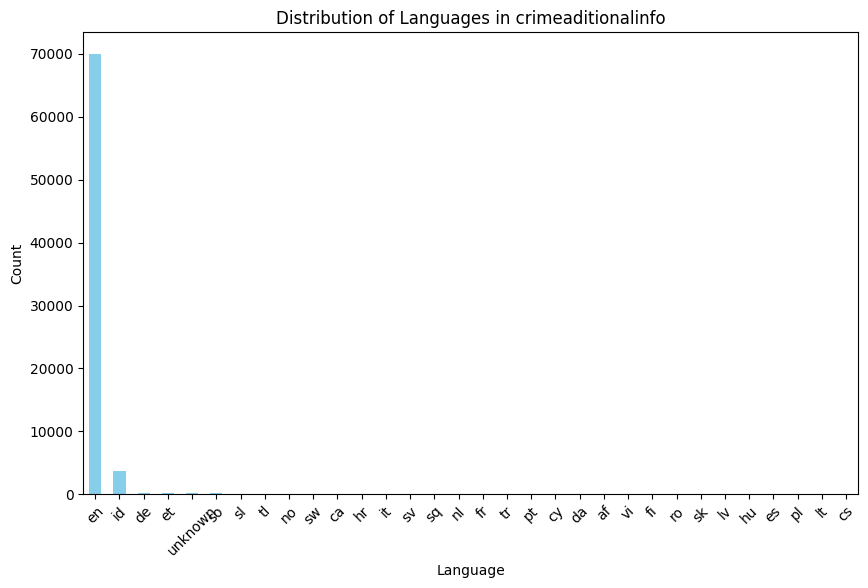

In [ ]:
# Plot language distribution
plt.figure(figsize=(10, 6))
df["language"].value_counts().plot(kind="bar", color="skyblue")
plt.xlabel("Language")
plt.ylabel("Count")
plt.title("Distribution of Languages in crimeaditionalinfo")
plt.xticks(rotation=45)
plt.show()


In [ ]:
stop_words = set(stopwords.words('english'))
indic_stopwords = set([
    "aur", "ki", "hai", "huyi", "ho", "mein", "ye", "ke", "jo", "saath", "ko",
    "bhi", "tatha", "par", "se", "kisi", "un", "apna", "tum", "main", "aap", "inhe",
    "in", "abhi", "ab", "woh", "hum", "unka", "is", "us", "kintu", "athva", "nahin"
])
stop_words=stop_words.union(indic_stopwords)


In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(text, lang):
    if not isinstance(text, str):
        return ""

    # Normalize Indic text
    if lang in ["hi", "bn", "ta", "te", "mr"]:
        normalizer = indic_normalize.Normalizer()
        text = normalizer.normalize(text)

    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenization
    words = text.split() if lang == "en" else indic_tokenize.trivial_tokenize(text)

    # Stopword removal and lemmatization
    if lang == "en":
        words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    elif lang in ["hi", "bn", "ta", "te", "mr"]:
        words = [word for word in words if word not in indic_stopwords]

    return " ".join(words)

In [ ]:
# Apply preprocessing
df["cleaned_crimeaditionalinfo"] = df.apply(lambda row: preprocess_text(row["crimeaditionalinfo"], row["language"]), axis=1)


In [ ]:
!pip install cleanlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 7.9 MB/s eta 0:00:00


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import cleanlab
from cleanlab.classification import CleanLearning
from sklearn.linear_model import LogisticRegression

In [ ]:
# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["cleaned_crimeaditionalinfo"])

In [ ]:
unique_main_categories = df["main_category"].unique()

# Create a mapping for the present categories starting from 0
category_mapping = {cat: idx for idx, cat in enumerate(unique_main_categories)}

# Map the main categories to numerical labels
df["main_category_label"] = df["main_category"].map(category_mapping)

Using Logistic Regressor

In [ ]:
# Apply Confident Learning to detect mislabeled data
clf = LogisticRegression()
cleaner = CleanLearning(clf)
cleaner.fit(X, df["main_category_label"].values)
df["predicted_main_category_label"] = cleaner.predict(X)
df["predicted_main_category"] = df["predicted_main_category_label"].map({v: k for k, v in category_mapping.items()})


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/cleanlab/count.py:1031: UserWarning: Duplicated some data across multiple folds to ensure training does not fail because these classes do not have enough data for proper cross-validation: {2}.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/cleanlab/filter.py:904: UserWarning: May not flag all label issues in class: 2, it has too few examples (see `min_examples_per_class` argument)
  warnings.warn(


In [ ]:
# Identify mislabeled rows
df["mislabeled"] = df["main_category"] != df["predicted_main_category"]


In [ ]:
mislabeled_count_lr = df["mislabeled"].sum()
print(f"Number of mislabeled data points: {mislabeled_count_lr}")

Number of mislabeled data points: 9548


Using LGBM

In [ ]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, df["main_category_label"], test_size=0.2, random_state=42)

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

params = {
    'objective': 'multiclass',
    'num_class': len(CATEGORY_TO_MAIN),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'verbose': -1
}


In [ ]:
lgbm_model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(10)],  # Include log_evaluation callback for verbose output
)

Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 0.497413	valid_1's multi_logloss: 0.521345
[20]	training's multi_logloss: 0.429724	valid_1's multi_logloss: 0.455483
[30]	training's multi_logloss: 0.395703	valid_1's multi_logloss: 0.423368
[40]	training's multi_logloss: 0.375093	valid_1's multi_logloss: 0.404622
[50]	training's multi_logloss: 0.361759	valid_1's multi_logloss: 0.39337
[60]	training's multi_logloss: 0.352496	valid_1's multi_logloss: 0.386438
[70]	training's multi_logloss: 0.345245	valid_1's multi_logloss: 0.381535
[80]	training's multi_logloss: 0.339423	valid_1's multi_logloss: 0.377833
[90]	training's multi_logloss: 0.334293	valid_1's multi_logloss: 0.375734
[100]	training's multi_logloss: 0.32984	valid_1's multi_logloss: 0.373793
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.32984	valid_1's multi_logloss: 0.373793


In [ ]:
# Predict categories
df["predicted_main_category_label_lgbm"] = np.argmax(lgbm_model.predict(X), axis=1)
df["predicted_main_category_lgbm"] = df["predicted_main_category_label_lgbm"].map({v: k for k, v in category_mapping.items()})

# Identify mislabeled rows
df["mislabeled_lgbm"] = df["main_category"] != df["predicted_main_category_lgbm"]


In [ ]:
# Count the number of mislabeled rows
mislabeled_count_lgbm = df["mislabeled_lgbm"].sum()
print(f"Number of mislabeled data points: {mislabeled_count_lgbm}")

Number of mislabeled data points: 11837


K_means

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["cleaned_crimeaditionalinfo"])

In [ ]:
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

75357 rows


,0,1,2,3,4,5,6,7,8,9,...,75347,75348,75349,75350,75351,75352,75353,75354,75355,75356
unknown,0.346242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sort,0.308631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
random,0.272201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
continue,0.268329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
added,0.239088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
final_df.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,75347,75348,75349,75350,75351,75352,75353,75354,75355,75356
unknown,0.346242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sort,0.308631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
random,0.272201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
continue,0.268329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
added,0.239088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import classification_report, accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [ ]:
NUM_CLUSTERS = 3  # Number of categories
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
df["predicted_main_category_cluster"] = kmeans.fit_predict(X)

In [ ]:
MAIN_CATEGORY_LABELS = list(CATEGORY_TO_MAIN.keys())

In [ ]:
cluster_to_category = {i: MAIN_CATEGORY_LABELS[i] for i in range(NUM_CLUSTERS)}
df["predicted_main_category_Kmeans"] = df["predicted_main_category_cluster"].map(cluster_to_category)

In [ ]:
# Identify mislabeled rows
df["mislabeled_Kmeans"] = df["main_category"] != df["predicted_main_category_Kmeans"]

# Count the number of mislabeled rows
mislabeled_count = df["mislabeled_Kmeans"].sum()
print(f"Number of mislabeled data points: {mislabeled_count}")

Number of mislabeled data points: 63029


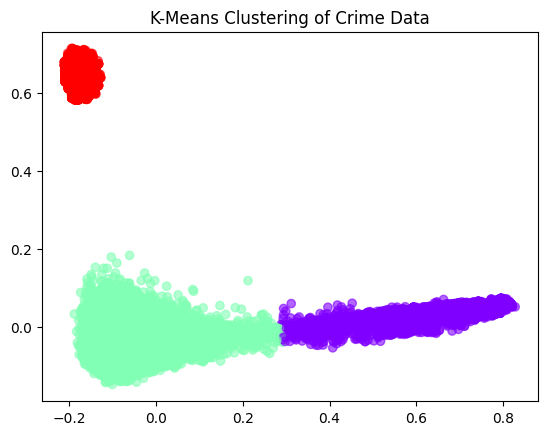

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.toarray())

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["predicted_main_category_cluster"], cmap="rainbow", alpha=0.6)
plt.title("K-Means Clustering of Crime Data")
plt.show()

In [ ]:
df.head(50)

,category,sub_category,crimeaditionalinfo,main_category,language,cleaned_crimeaditionalinfo,main_category_label,predicted_main_category_label,predicted_main_category,mislabeled,predicted_main_category_label_lgbm,predicted_main_category_lgbm,mislabeled_lgbm,predicted_main_category_cluster,predicted_main_category_Kmeans,mislabeled_Kmeans
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,I had continue received random calls and abusi...,Other Cyber Crimes,en,continue received random call abusive message ...,0,0,Other Cyber Crimes,False,0,Other Cyber Crimes,False,1,WomenChildren Related Crime,True
1,Online Financial Fraud,Fraud CallVishing,The above fraudster is continuously messaging ...,Financial Fraud,en,fraudster continuously messaging asking pay mo...,1,0,Other Cyber Crimes,True,0,Other Cyber Crimes,True,1,WomenChildren Related Crime,True
2,Online Gambling Betting,Online Gambling Betting,He is acting like a police and demanding for m...,Financial Fraud,en,acting like police demanding money adding sect...,1,0,Other Cyber Crimes,True,0,Other Cyber Crimes,True,1,WomenChildren Related Crime,True
3,Online and Social Media Related Crime,Online Job Fraud,In apna Job I have applied for job interview f...,Other Cyber Crimes,en,job applied job interview telecalling resource...,0,0,Other Cyber Crimes,False,0,Other Cyber Crimes,False,1,WomenChildren Related Crime,True
4,Online Financial Fraud,Fraud CallVishing,I received a call from lady stating that she w...,Financial Fraud,en,received call lady stating send new phone vivo...,1,0,Other Cyber Crimes,True,0,Other Cyber Crimes,True,1,WomenChildren Related Crime,True
5,Online Financial Fraud,UPI Related Frauds,FRAUD \t UPI PAYTM \r\nBANK \tPunjab National ...,Financial Fraud,en,fraud upi paytm bank punjab national bank incl...,1,1,Financial Fraud,False,1,Financial Fraud,False,0,Financial Fraud,False
6,Online Financial Fraud,Fraud CallVishing,Sir I am Prabhat Singh jat An app on playstor...,Financial Fraud,en,sir prabhat singh jat app playstore name rupee...,1,0,Other Cyber Crimes,True,0,Other Cyber Crimes,True,1,WomenChildren Related Crime,True
9,Any Other Cyber Crime,Other,Details entered in pdf file Person posing as A...,Other Cyber Crimes,en,detail entered pdf file person posing army off...,0,1,Financial Fraud,True,1,Financial Fraud,True,1,WomenChildren Related Crime,True
10,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,I received a Whatsapp number in Happn Dating a...,Other Cyber Crimes,en,received whatsapp number happn dating app text...,0,0,Other Cyber Crimes,False,0,Other Cyber Crimes,False,1,WomenChildren Related Crime,True
11,Any Other Cyber Crime,Other,Someone changed my email id nd contact number ...,Other Cyber Crimes,en,someone changed email id nd contact number usi...,0,0,Other Cyber Crimes,False,0,Other Cyber Crimes,False,1,WomenChildren Related Crime,True
